In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [207]:
"""Reading the Data from the Kaggle downloaded data set"""
data = pd.read_csv('Admission_Predict_Ver1.1.csv')
data.isnull().sum() #Ensuring the dataframe has no missing values
data_ready = data.drop(labels='Serial No.',axis=1) #Serial No. is not a feature influencing the Chance of Admit
data_ready.head()
columns = list(data_ready)
data_ready.describe() #Describing the data for analytical inspection

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


Top 3 most correlated independent variables with the dependent variable ['CGPA', 'GRE Score', 'TOEFL Score']


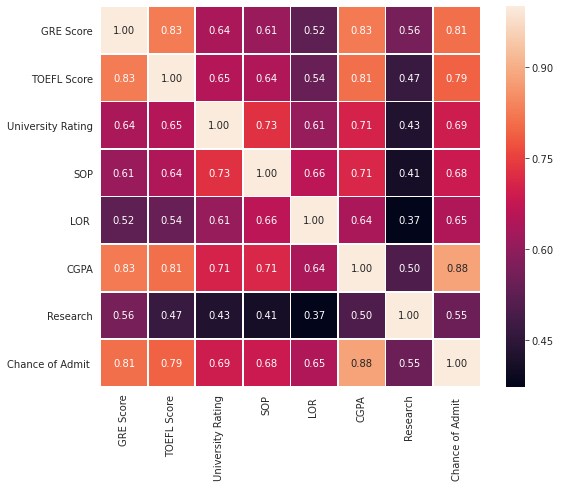

In [208]:
"""Plot Confusion Matrix to show the correlation between the independent variables and the dependent one """

import seaborn as sns
corrs = data_ready.corr()
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corrs,square=True,annot=True,fmt='0.2f',linewidths=.8,cmap="rocket")
    
corr_chance =  data_ready[data_ready.columns[0:]].corr()[str(columns[-1])][:-1] #corr with respect to Chance of Admit
sort_chance = sorted(corr_chance)[-3:]
top3 = []
for i in sort_chance:
    indx = corr_chance[corr_chance == i].index[0]
    top3.append(indx)
print("Top 3 most correlated independent variables with the dependent variable", top3[::-1])

'The linear relationship can be clearly seen from these graphs'

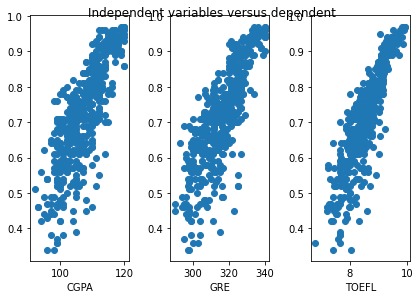

In [209]:
"""Plotting the relationship between the top three correlated independent variable and the Chance of Admit"""
chance = data_ready[str(columns[-1])]
x_cgpa = data_ready[top3[0]]
x_gre = data_ready[top3[1]]
x_toefl = data_ready[top3[2]]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Independent variables versus dependent')
ax1.scatter(x_cgpa, chance)
ax1.set_xlabel("CGPA")
ax2.scatter(x_gre, chance)
ax2.set_xlabel("GRE")
ax3.scatter(x_toefl, chance)
ax3.set_xlabel("TOEFL")
"""The linear relationship can be clearly seen from these graphs"""

In [210]:
def get_data(dataframe):
    """Separates the independent variables from the dependent one in the data set"""
    """Adds the intercept to the X vector"""
    X = dataframe.iloc[:,:-1] 
    y = dataframe["Chance of Admit "].tolist() 
    X = np.c_[np.ones(len(X)),X] 
    
    return X,y    

def scale(data):
    """The scaling is done through a mean normalization approach such that the mean of the features is 0"""
    newval = data - np.mean(data)
    return newval / np.std(data)

def scale_alldata(dataframe):
    """Scalling the entire data set"""
    for i in columns[:-1]:
            #print(i)
            dataframe[i] = scale(dataframe[i])    
    return dataframe 

data_ready = scale_alldata(data_ready) #Data ready for modelling


In [211]:
def splitting(X,y,k):
    """Splitting the data into the training and testing set by choosing randomly the indexes to make up each"""

    list_indx = list(np.arange(0,500))
    train_indx = random.sample(list_indx,k=400) # The train data consists of 400 examples.
    test_indx = [i for j, i in enumerate(list_indx) if j not in train_indx]
    if bool(set(train_indx) & set(test_indx)) == False: #Test if indexes overlap
        X_train = np.take(X,train_indx,axis=0)
        X_test = np.take(X,test_indx,axis=0)

        y_train = np.take(y,train_indx)
        y_test = np.take(y,test_indx)
        
    return X_train,y_train,X_test,y_test

def shuffle(X,y): 
    """Shuffling the data to ensure randomness in the distribution of the data"""
    np.random.seed(1)
    xy = list(zip(X, y))
    random.shuffle(xy)
    X, y = zip(*xy)
    
    return X,y


In [294]:
def predict(X,theta_update):
    """The prediction of the dependent variable y"""
    return X.dot(theta_update)
    #return np.dot(X, theta_update)

def cost_func(X,y,theta):
    """Loss function"""
    n = X.shape[0] #for MSE
    j = (1/2)*np.sum((np.dot(X,theta)-y)**2)
    return j
    
def r_sq(y_real,y_pred):
    """R^2 measurement"""
    y_avg = (1/len(y_real))*np.sum(y_real)
    err = np.sum((y_real-y_pred)**2)
    denom = np.sum((y_real-y_avg)**2)
    val = 1 - (err/denom)
    return val

def rmse(y_real, y_pred):
    """RMSE measurement"""
    return np.sqrt(((y_pred - y_real) ** 2).mean())

def split_mini(X,y,batch_size):
    """Splitting the data into mini-batches"""
    X_batch,y_batch = shuffle(X,y)
    if len(X_batch)%batch_size !=0: 
        n_minibatches = len(X_batch) // batch_size 
        i = 0
        mini_batches_x = []
        mini_batches_y = []
        for i in range(n_minibatches + 1): 
             X_mini = X_batch[i * batch_size:(i + 1)*batch_size] 
             y_mini = y_batch[i * batch_size:(i + 1)*batch_size]
             mini_batches_x.append(X_mini) 
             mini_batches_y.append(y_mini)
    else:
        n_minibatches = len(X_batch) // batch_size 
        i = 0
        mini_batches_x = []
        mini_batches_y = []
        for i in range(n_minibatches): 
             X_mini = X_batch[i * batch_size:(i + 1)*batch_size] 
             y_mini = y_batch[i * batch_size:(i + 1)*batch_size]
             mini_batches_x.append(X_mini) 
             mini_batches_y.append(y_mini)
        
    return mini_batches_x,mini_batches_y
    

In [213]:
"""STANDARD GRADIENT DESCENT IMPLEMENTATION"""
   
def gradient_descent(X,y,learning_rate,epochs):
    
    loss_list = []
    m = X.shape[0] 
    theta = np.zeros(X.shape[1])
    for i in range(epochs):
        predict_y = np.dot(X,theta) #predicted values 
        loss_val = predict_y-y      # difference between the true values and the predicted ones

        grad = np.dot(loss_val,X)*(1/m) #Derivative of the loss function
        theta = theta - learning_rate*grad #Update of the parameters
        cost = cost_func(X,y,theta) #Evaluate the cost  
        loss_list.append(cost)
        #print(f"Iteration : {i}; Cost : {cost}")
        
    return theta,loss_list

In [214]:
"""STOCHASTIC GRADIENT DESCENT"""

def sgd(X,y,learning_rate,epochs):
    theta = np.zeros(X.shape[1])
    loss_list = []    
    for i in range(epochs): 
        #print('Epoch',i)
        rand_data = shuffle(X,y)
        loss_list = []
        x_use = np.asarray(rand_data[0])
        y_use = np.asarray(rand_data[1])
        for x1,y1 in zip(x_use,y_use):
            loss = x1.dot(theta)-y1
            grad = np.dot(x1,loss)
            theta = theta - learning_rate*grad
            cost = cost_func(x1,y1,theta)
            loss_list.append(cost)
            #print(f"Iteration : {i}; Cost : {cost}")
   
    return theta,loss_list

In [280]:
def mini(X,y,learning_rate,batch_size,epochs):
    theta = np.zeros(X.shape[1])
    loss_list = []
    for i in range(epochs): 
        #print('Epoch',i)
        x_mini,y_mini = split_mini(X,y,batch_size)
        for j in range(len(x_mini)):
            x_use = np.asarray(x_mini[j])
            y_use = np.asarray(y_mini[j])
            if len(x_use) != 0:
                h = np.dot(x_use,theta)
                #h = x_use.dot(theta)
                grad = (2)*x_use.T.dot(h-y_use)
                theta = theta - learning_rate*grad*(1/batch_size)
                cost = cost_func(x_use,y_use,theta)
                loss_list.append(cost)
            else:
                print("wrong")
                break

        
    return theta,loss_list

In [216]:
"""Perform grid search to identify the best values for the hyperparameters for GD"""
def hyperparameters(X_train,y_train,learning_range,epochs,name_model,batch):
    
    lr_range = learning_range
    iterations = epochs
    r2_list = []
    rmse_list = []
    all_losses = []
    for i in lr_range:
        theta_test = np.zeros(X_train.shape[1])
        if name_model == 'STD':
            thetanew,lossval = gradient_descent(X = X_train, y = y_train,learning_rate=i,epochs=iterations)
        elif name_model == 'SGD':
            thetanew,lossval = sgd(X = X_train, y = y_train,learning_rate=i,epochs=iterations)
        elif name_model == 'MINI':
            thetanew,lossval = mini(X = X_train, y = y_train,learning_rate=i,batch_size = batch,epochs=iterations)
        y_pred = predict(X_train,thetanew)
        r2 = r_sq(y_train,y_pred)
        rmse_val = rmse(y_train,y_pred)
        r2_list.append(r2)
        rmse_list.append(rmse_val)
        all_losses.append(lossval)
        
    data_performance = {'Learning rates':lr_range,'R^2':r2_list,'RMSE':rmse_list}
    df = pd.DataFrame(data = data_performance)
    return df, all_losses



   Learning rates       R^2      RMSE
0           0.001  0.730573  0.071813
1           0.005  0.808785  0.060498
2           0.010  0.808951  0.060472
3           0.050  0.808952  0.060472
4           0.100  0.808952  0.060472
Best Learning Rate: 0.05


Text(0, 0.5, 'R squared')

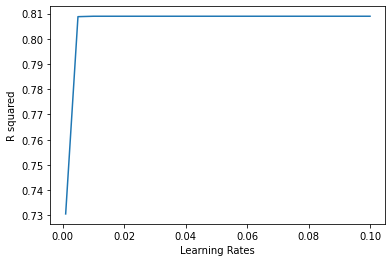

In [218]:
"""STANDARD GRADIENT DESCENT: GRID SEARCH"""
print(dfperf)
lr = [0.001,0.005,0.01,0.05,0.1]
epochval = 3000
dfperf,loss_list = hyperparameters(X_train,y_train,lr,epochval,'STD',batch=0) 

"""Give the best learning rate"""
r2_val = list(dfperf['R^2'])
rmse_val = list(dfperf['RMSE'])
lr_val = list((dfperf['Learning rates']))
min_rmse = min(rmse_val)
indx_min = rmse_val.index(min_rmse)
print("Best Learning Rate:", lr_val[indx_min])

plt.plot(lr_val,r2_val)
plt.xlabel("Learning Rates")
plt.ylabel("R squared")


In [241]:
"""STANDARD GRADIENT DESCENT : FINAL PREDICTION FOR THE TEST SET USING THE BEST PARAMETERS"""
lr = 0.01
iterations = 3000

X,y = get_data(data_ready)
X_train,y_train,X_test,y_test = splitting(X,y,k=400)

theta_test = np.zeros(X_train.shape[1])
thetanew,losslist = gradient_descent(X = X_train, y = y_train,learning_rate=lr,epochs=iterations)
y_pred = predict(X_test,thetanew)
data_pred = {'Chance of Admit':y_test,'Prediction':y_pred}
df = pd.DataFrame(data= data_pred)

a = r_sq(y_test,y_pred)
b = rmse(y_test,y_pred)

print("R2",a)
print("RMSE",b)

R2 0.8647935177303137
RMSE 0.051420056900356656


In [260]:
"""SGD : GRID SEARCH """
X, y = get_data(data_ready)
X_train_sgd,y_train_sgd,X_test_sgd,y_test_sgd = splitting(X,y,k=400)
lr_sgd = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
#lr_sgd = [0.0001,0.0005,0.001]
ep_sgd = 1000
df_sgd,_ = hyperparameters(X_train_sgd,y_train_sgd,lr_sgd,ep_sgd, name_model = 'SGD',batch=0)
print(df_sgd)

   Learning rates       R^2      RMSE
0          0.0001  0.817222  0.060568
1          0.0005  0.817208  0.060570
2          0.0010  0.817221  0.060568
3          0.0050  0.811909  0.061442
4          0.0100  0.814768  0.060973
5          0.0500  0.783253  0.065956
6          0.1000  0.617986  0.087563


In [262]:
"""SGD : FINAL PREDICTION FOR THE TEST SET USING THE BEST PARAMETERS"""
lr = 0.001
iterations = 1500

theta_sgd,loss_sgd = sgd(X_train_sgd,y_train_sgd,lr,iterations)
y_pred_sgd = predict(X_test_sgd,theta_sgd)
a = r_sq(y_test_sgd,y_pred_sgd)
b = rmse(y_test_sgd,y_pred_sgd)
print("R squared is",a)
print("RMSE is",b)
data_sgd = {'Chance of Admit':y_test_sgd,'Prediction':y_pred_sgd}
df_sgd = pd.DataFrame(data= data_sgd)
print(df_sgd)

R squared is 0.8398675505524198
RMSE is 0.055262540613602674
    Chance of Admit  Prediction
0              0.68    0.600041
1              0.54    0.648397
2              0.95    0.961650
3              0.94    0.962272
4              0.74    0.717834
..              ...         ...
95             0.71    0.732347
96             0.79    0.817184
97             0.78    0.715875
98             0.76    0.766572
99             0.87    0.837277

[100 rows x 2 columns]


In [309]:
"""MINI: GRID SEARCH ON BATCH SIZE"""

X, y = get_data(data_ready)
X_train,y_train,X_test,y_test= splitting(X,y,k=400)
lr_mini = [0.0001,0.001,0.01,0.1]
#lr_sgd = [0.0001,0.0005,0.001]
batch_list = [2,4,8,16,32,64]
ep = 500
list_fr = []
for j in batch_list:
    df_mini,_ = hyperparameters(X_train,y_train,lr_mini,ep, name_model = 'MINI',batch=j)
    list_fr.append(df_mini)
#print(list_fr)


In [307]:
"""MINI : FINAL PREDICTION FOR THE TEST SET USING THE BEST PARAMETERS"""
lr = 0.001
batchs = 4
iterations = 1500

X, y = get_data(data_ready)
X_train,y_train,X_test,y_test = splitting(X,y,k=400)

theta_mini,loss_mini = mini(X_train,y_train,lr,batchs,iterations)
y_pred_mini = predict(X_test,theta_mini)
a = r_sq(y_test,y_pred_mini)
b = rmse(y_test,y_pred_mini)
print("R squared is",a)
print("RMSE is",b)
data_mini = {'Chance of Admit':y_test,'Prediction':y_pred_mini}
df_mini = pd.DataFrame(data= data_sgd)
print(df_mini)

R squared is 0.8515758627642077
RMSE is 0.060515568613697134
    Chance of Admit  Prediction
0              0.68    0.600041
1              0.54    0.648397
2              0.95    0.961650
3              0.94    0.962272
4              0.74    0.717834
..              ...         ...
95             0.71    0.732347
96             0.79    0.817184
97             0.78    0.715875
98             0.76    0.766572
99             0.87    0.837277

[100 rows x 2 columns]
